In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import joblib

In [10]:
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Load the data (Assuming the file is named 'german_credit_data.csv')
df = pd.read_csv("german_credit_data.csv")

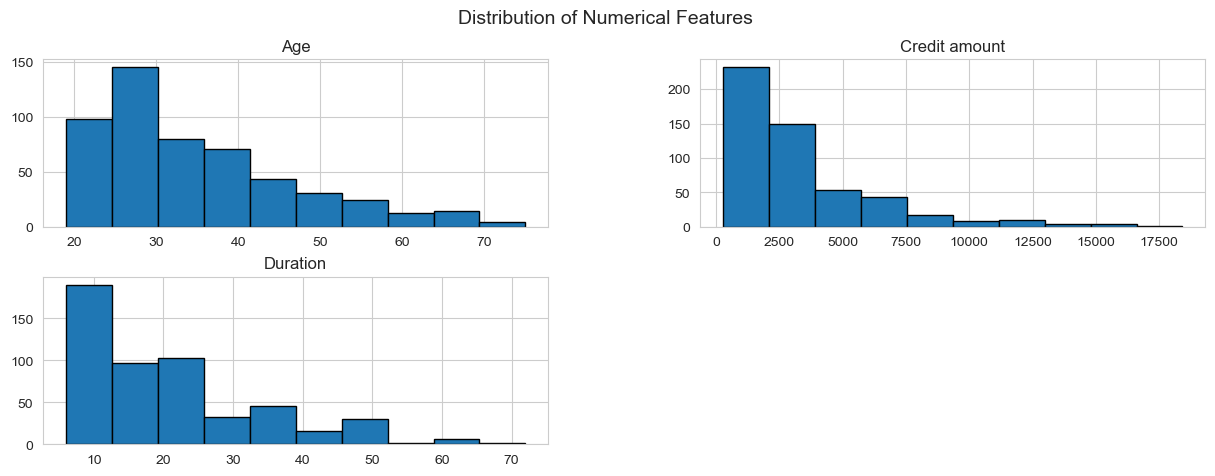

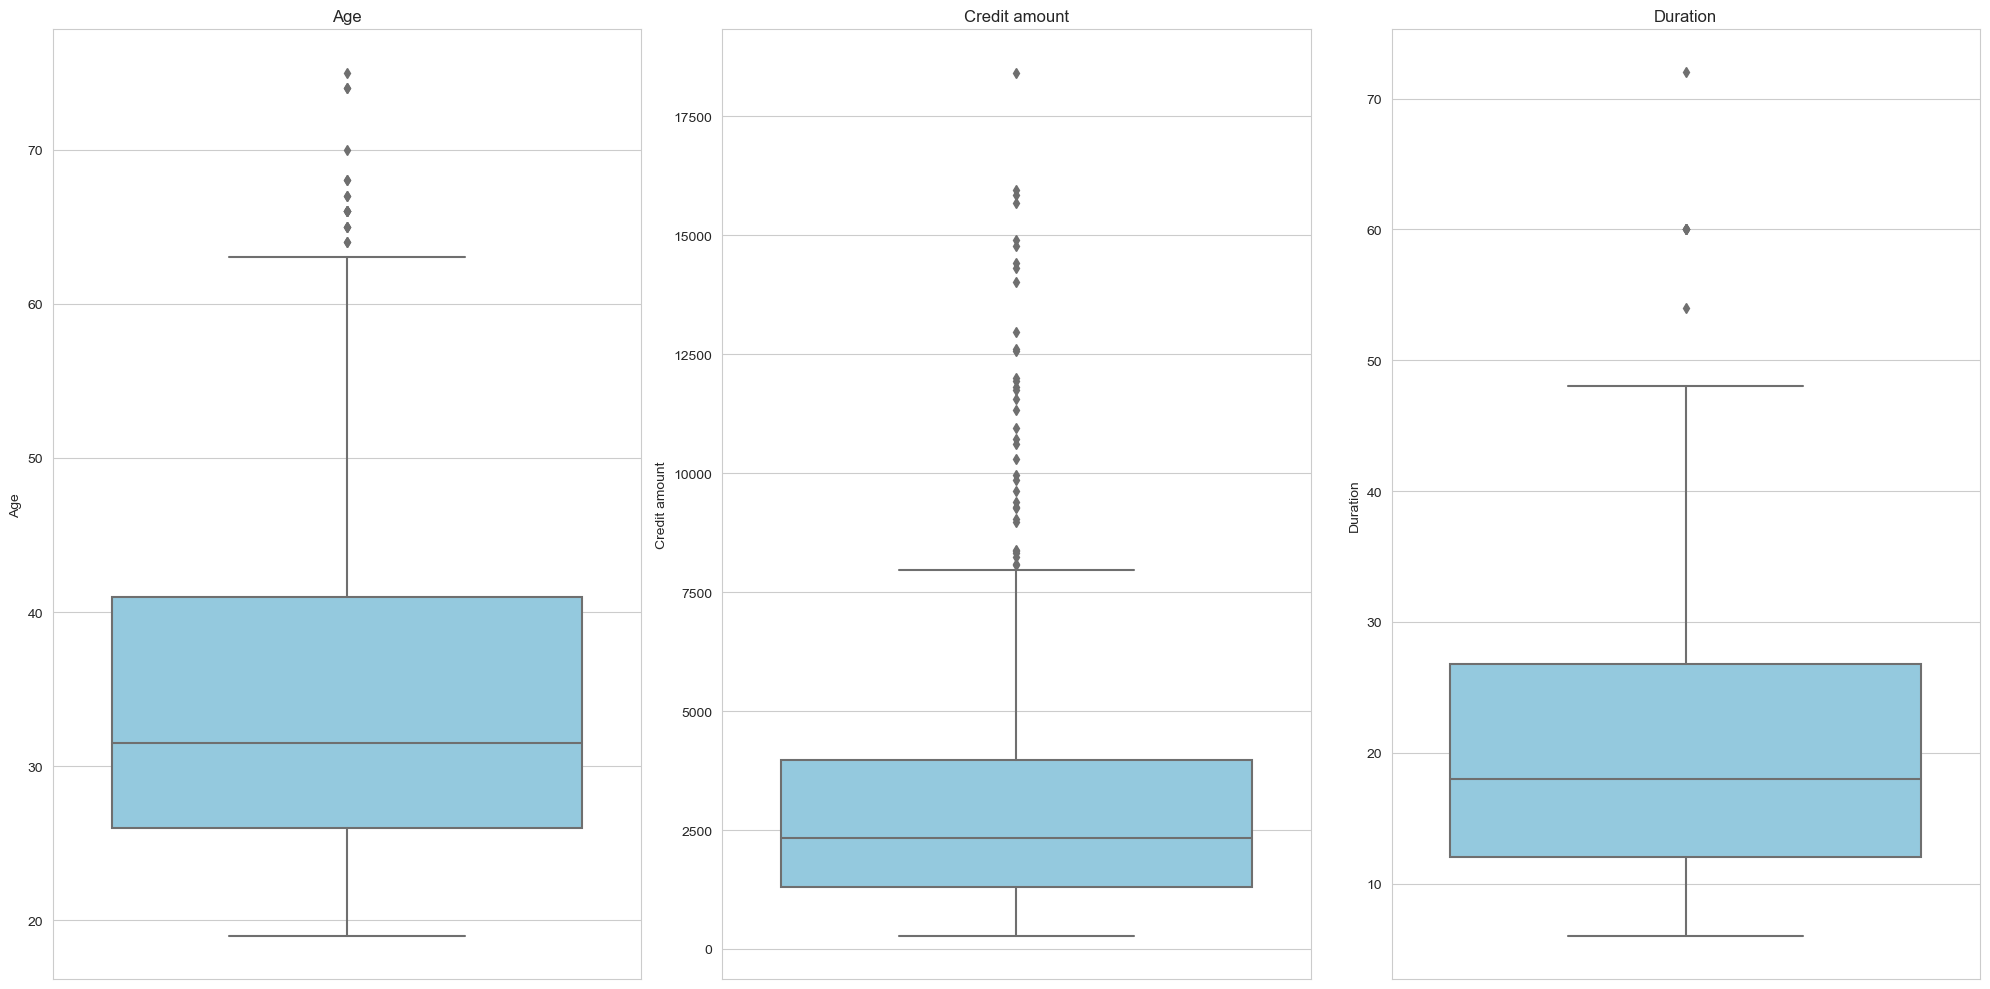

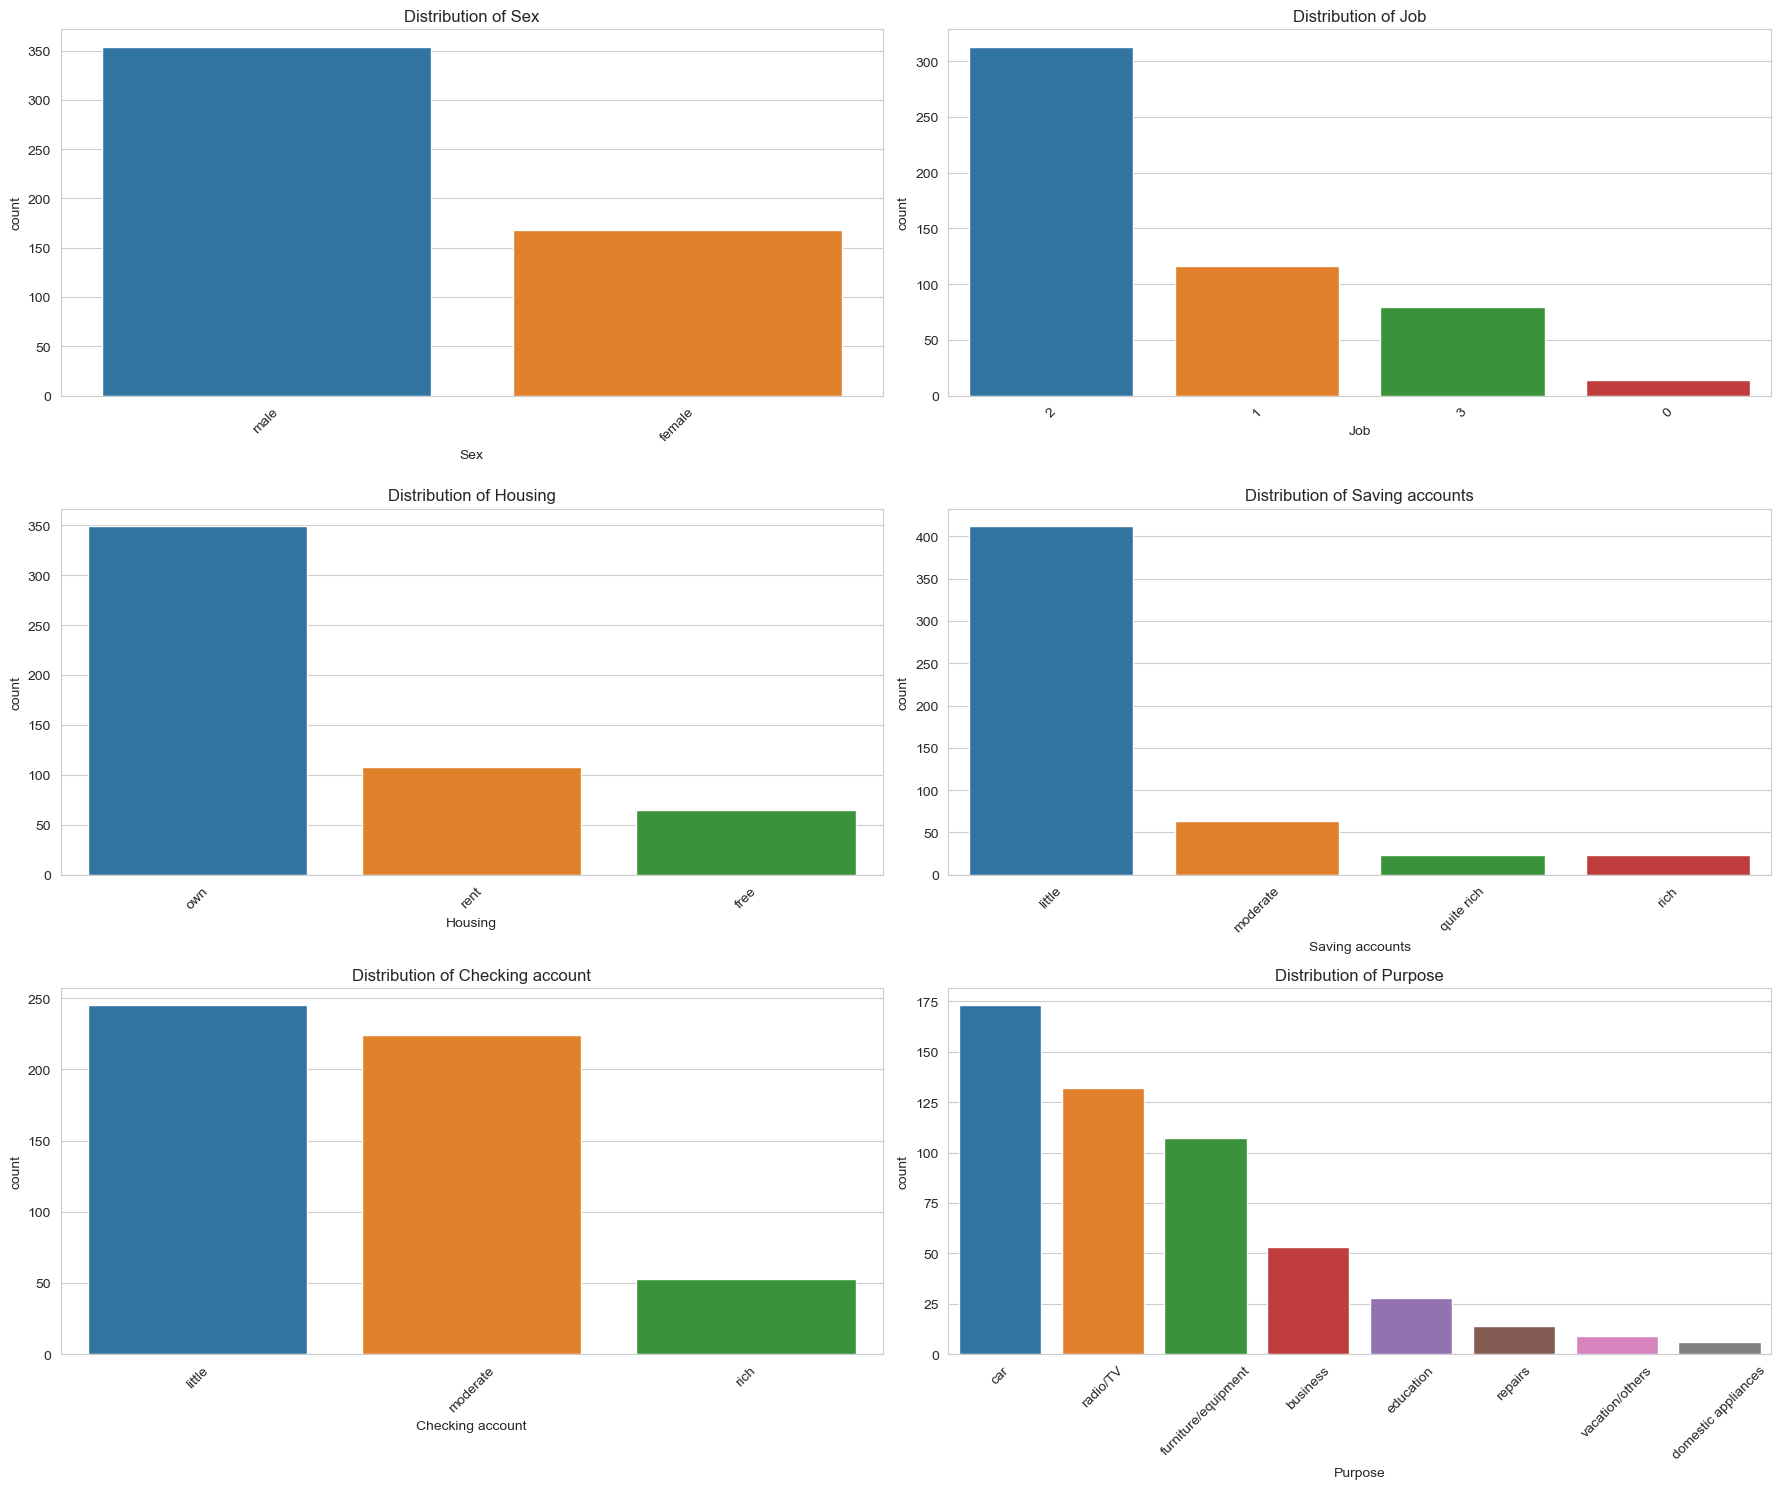

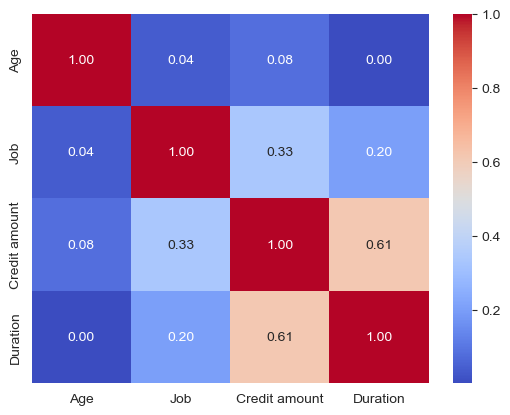

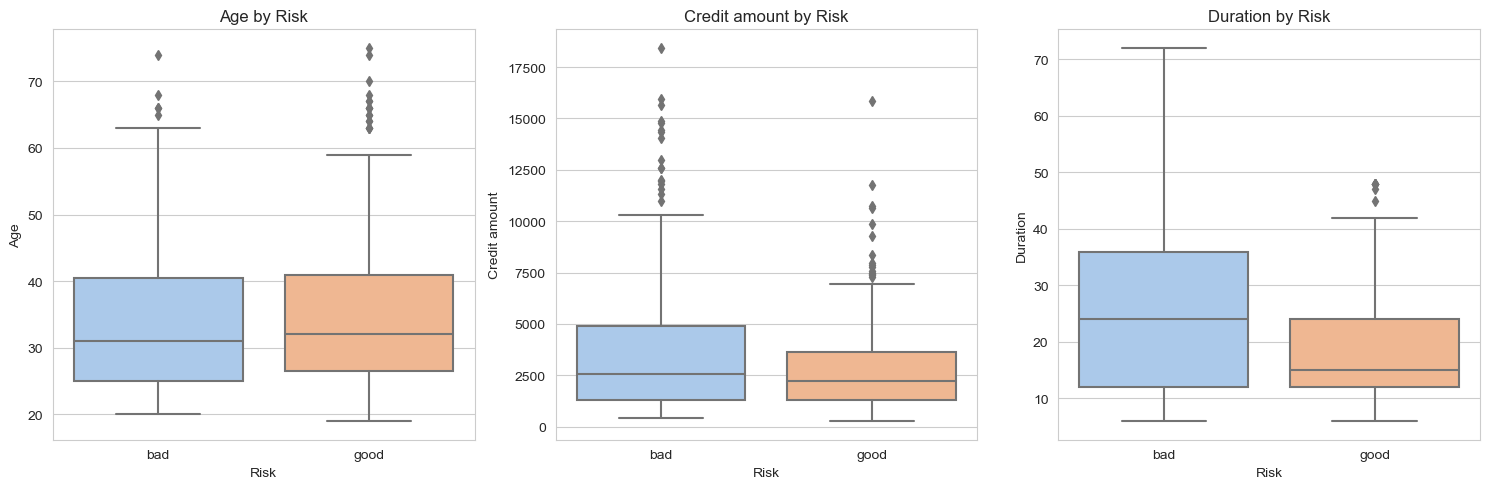

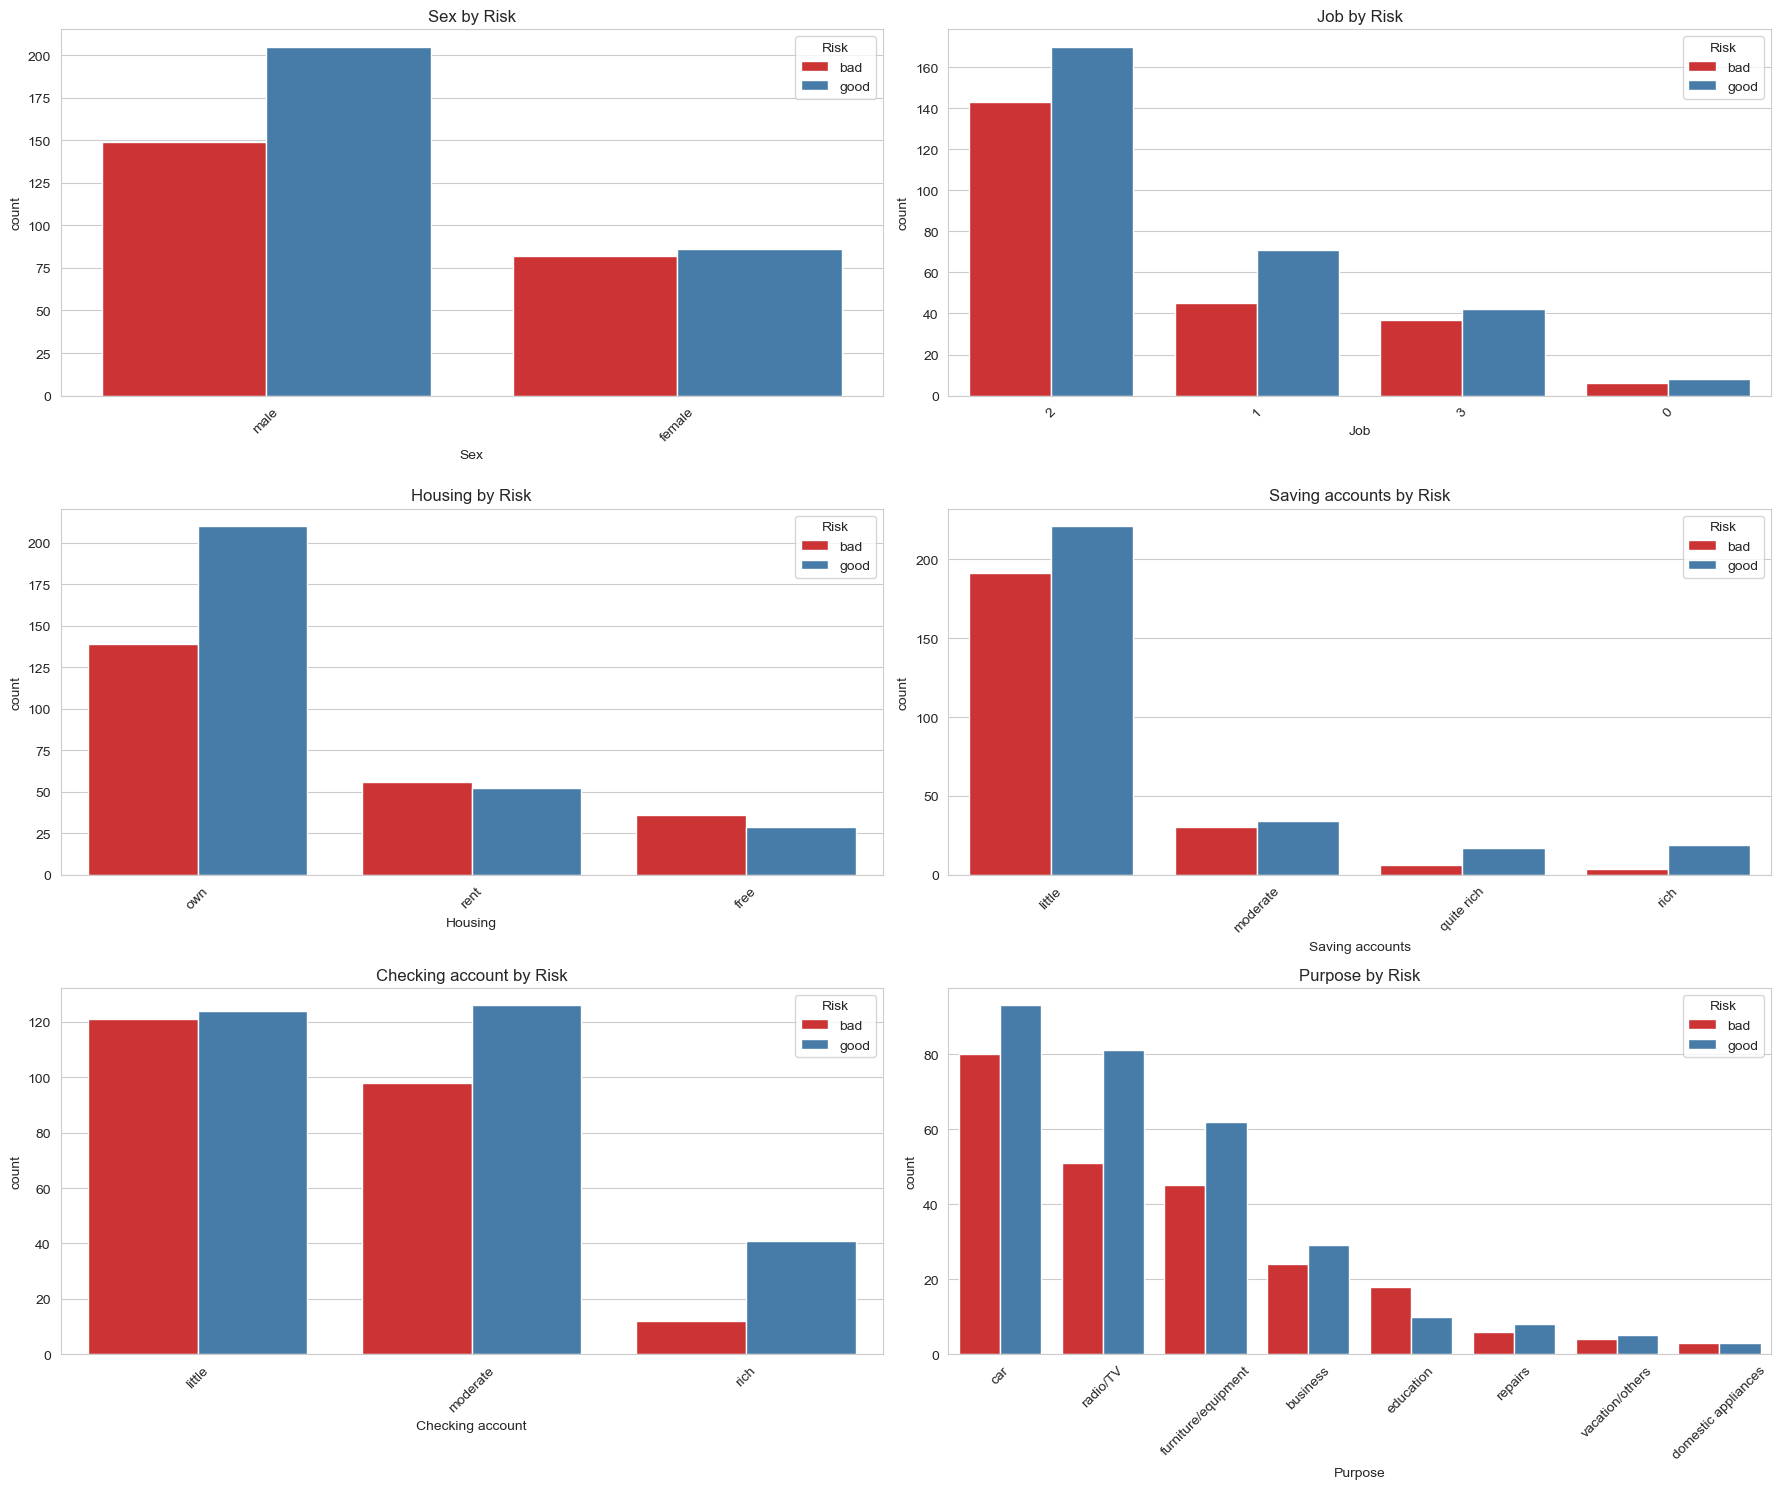

In [11]:
# Drop the initial index column (Unnanmed: 0)
df.drop(columns=['Unnamed: 0'], inplace=True)

# Handle missing values by dropping rows
# The decision is made to drop rows with missing data in 'Saving accounts' or 'Checking account'
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Define numerical and categorical columns
numerical_cols = ['Age', 'Credit amount', 'Duration']
categorical_cols = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

# --- Univariate Analysis: Histograms [12:12] ---
df[numerical_cols].hist(bins=10, edgecolor='black', figsize=(15, 5))
plt.suptitle('Distribution of Numerical Features', fontsize=14)
plt.show()

# --- Univariate Analysis: Box Plots [13:28] ---
plt.figure(figsize=(20, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()

# --- Univariate Analysis: Count Plots for Categorical Features [16:56] ---
plt.figure(figsize=(18, 15))
for i, col in enumerate(categorical_cols):
    plt.subplot(3, 2, i+1)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Bivariate Analysis: Correlation Matrix [19:54] ---
corr = df[['Age', 'Job', 'Credit amount', 'Duration']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

# --- Risk Analysis: Numeric Features by Risk (Box Plots) [27:00] ---
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data=df, x='Risk', y=col, palette='pastel')
    plt.title(f'{col} by Risk')
plt.tight_layout()
plt.show()

# --- Risk Analysis: Categorical Features by Risk (Count Plots) [29:23] ---
# Note: 'Purpose' is in categorical_cols but will be dropped for modeling
categorical_cols_for_plot = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

plt.figure(figsize=(18, 15))
for i, col in enumerate(categorical_cols_for_plot):
    plt.subplot(3, 2, i+1)
    sns.countplot(data=df, x=col, hue='Risk', palette='Set1', order=df[col].value_counts().index)
    plt.title(f'{col} by Risk')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Define features (excluding 'Purpose' as shown in [31:42])
features = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration']
target = 'Risk'

df_model = df[features + [target]].copy()

# List of categorical columns to encode in the model dataset
# 'Job' is numeric 0-3 but is treated as categorical for encoding
categorical_cols_model = df_model.select_dtypes(include='object').columns.tolist()

label_encoders = {}
for col in categorical_cols_model:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le
    # Export encoders for use in Streamlit app [34:21]
    joblib.dump(le, f'{col}_encoder.pkl')

# Encode the target column 'Risk' (Good: 1, Bad: 0) [35:05]
le_target = LabelEncoder()
df_model[target] = le_target.fit_transform(df_model[target])
joblib.dump(le_target, 'target_encoder.pkl')

# Define X (features) and y (target) [37:07]
X = df_model.drop(target, axis=1)
y = df_model[target]

# Train-Test Split [37:37]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [13]:
# --- Helper Function for Training and Tuning [39:49] ---
def train_model(model, param_grid, X_train, y_train, X_test, y_test):
    # Initialize GridSearchCV
    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    
    # Train the model
    grid.fit(X_train, y_train)
    
    # Get the best estimator
    best_model = grid.best_estimator_
    
    # Make predictions and evaluate
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Return results
    return best_model, accuracy, grid.best_params_

# --- 1. Decision Tree Classifier [42:58] ---
dt_model = DecisionTreeClassifier(random_state=1, class_weight='balanced')
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
best_dt, acc_dt, params_dt = train_model(dt_model, dt_param_grid, X_train, y_train, X_test, y_test)
print(f"Decision Tree Accuracy: {acc_dt}")
print(f"Best Parameters: {params_dt}")

# --- 2. Random Forest Classifier [45:37] ---
rf_model = RandomForestClassifier(random_state=1, class_weight='balanced', n_jobs=-1)
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
best_rf, acc_rf, params_rf = train_model(rf_model, rf_param_grid, X_train, y_train, X_test, y_test)
print(f"Random Forest Accuracy: {acc_rf}")
print(f"Best Parameters: {params_rf}")

# --- 3. Extra Trees Classifier [47:53] ---
et_model = ExtraTreesClassifier(random_state=1, class_weight='balanced', n_jobs=-1)
et_param_grid = rf_param_grid # Use the same grid
best_et, acc_et, params_et = train_model(et_model, et_param_grid, X_train, y_train, X_test, y_test)
print(f"Extra Trees Accuracy: {acc_et}")
print(f"Best Parameters: {params_et}")

# --- 4. XGBoost Classifier [49:29] ---
scale_pos_weight = (y_train[y_train == 0].sum() / y_train[y_train == 1].sum())

xgb_model = XGBClassifier(
    random_state=1,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
}
best_xgb, acc_xgb, params_xgb = train_model(xgb_model, xgb_param_grid, X_train, y_train, X_test, y_test)
print(f"XGBoost Accuracy: {acc_xgb}")
print(f"Best Parameters: {params_xgb}")

# --- Export the Best Model (Extra Trees) [52:54] ---
joblib.dump(best_et, 'extra_trees_credit_model.pkl')

Decision Tree Accuracy: 0.580952380952381
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Random Forest Accuracy: 0.6190476190476191
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Extra Trees Accuracy: 0.6476190476190476
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
XGBoost Accuracy: 0.4380952380952381
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}


C:\Users\Ronak\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:52:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


['extra_trees_credit_model.pkl']

In [14]:

print(np.__version__)
print(pd.__version__)

1.24.3
2.0.3


In [16]:
!pip show python

In [17]:
import sys
print(sys.version)


3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [3]:
print(pd.__version__)


2.0.3


In [5]:
print(joblib.__version__)

1.3.2


In [7]:
import sklearn
print(sklearn.__version__)


1.3.0


In [8]:
import xgboost

In [9]:
print(xgboost.__version__)

3.1.1
